In [1]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [2]:
dt = pd.read_csv('sales_train_validation.csv')
dt = dt.astype({col: 'int32' for col in dt.select_dtypes('int64').columns})
dt['Mean_sales'] = dt.mean(axis=1, numeric_only=True)
dt['Zeros']= dt[dt == 0].count(axis=1)/len(dt.columns)

In [3]:
cal = pd.read_csv('calendar.csv')
cal['date'] = pd.to_datetime(cal['date'])
cal = cal.astype({col: 'int32' for col in cal.select_dtypes('int64').columns})
cal_1 = cal[0:1941]

In [4]:
prices = pd.read_csv('sell_prices.csv')

In [5]:
def get_tm_ser(lc):
    #print(lc)
    dt_item_n = dt.iloc[[lc]]

    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dt_item_n = pd.melt(dt_item_n, 
                        id_vars = catcols, 
                        value_vars = [col for col in dt.columns if col.startswith('d_')], 
                        var_name = 'd', 
                        value_name = 'sales')
    lst = dt_item_n.loc[0, :].values.tolist()
    id_add = lst[0]
    it_add = lst[1]
    dep_add = lst[2]
    store_add = lst[3]
    cat_add = lst[4]
    state_add = lst[5]
    print(id_add)
    for i in range(28):
        j = i+1914
        day_str = 'd_'+str(j)
        add_row ={'id': id_add, 'item_id': it_add, 'dept_id': dep_add, 'store_id': store_add, 'cat_id': cat_add, 
                  'state_id': state_add, 'd': day_str, 'sales': -1}
        dt_item_n = dt_item_n.append(add_row, ignore_index=True)

    dt_item_n = dt_item_n.merge(cal, on= "d", copy = False)
    dt_item_n['price']=0.0

    price_curr = prices[(prices['store_id'] == store_add) & (prices['item_id'] == it_add)] 
    week_list = price_curr['wm_yr_wk'].tolist()
    #print(week_list)
    for i, row in dt_item_n.iterrows():
        week = row['wm_yr_wk']
        if (week in week_list): 
            price =  price_curr.loc[price_curr['wm_yr_wk'] == week, 'sell_price'].iloc[0]
        else:
            price = 0
        dt_item_n.at[i, 'price'] = price
    return dt_item_n

In [6]:
def plot_ser(i):
    df = get_tm_ser(i)
    df_train = df[:-28]
    dates = df_train['date'].tolist()
    sales = df_train['sales'].tolist()
    plt.rcParams["figure.figsize"] = (20,6)
    plt.scatter(dates, sales, s=15, c='royalblue')
    ax = plt.gca()
    ax.set_ylabel('Sales')
    ax.set_xlabel('Dates')
    plt.show()

HOBBIES_1_012_CA_1_validation


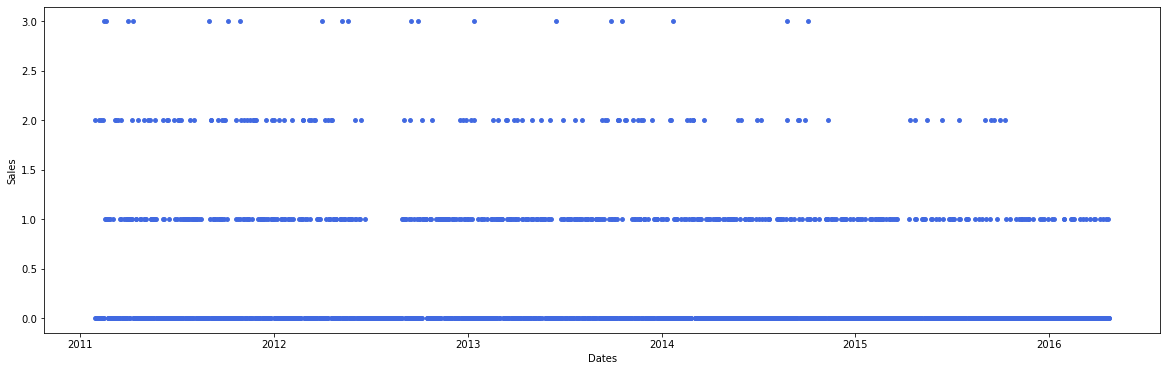

In [7]:
i = 11
plot_ser(i)   #plot individual item wise series by index value

In [8]:
dt.Mean_sales.describe()    #Mean daily saily of each item across all the individual series

count    30490.000000
mean         1.126322
std          2.727249
min          0.005227
25%          0.185572
50%          0.443283
75%          1.062075
max        130.947203
Name: Mean_sales, dtype: float64

In [9]:
dt.Zeros.describe()   #Approximate percentage of zero sales on a day across all the individual series

count    30490.000000
mean         0.679476
std          0.222957
min          0.001563
25%          0.534896
50%          0.732812
75%          0.864062
max          0.992708
Name: Zeros, dtype: float64